## lets see if we can compare some tracer cross-sections to see if the model is getting stuff in the right spot

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from cmocean import cm
from scipy.interpolate import griddata, interpn
import datetime

import warnings
warnings.filterwarnings("ignore")

In [2]:
grid = xr.open_dataset('/data1/parker/LO_data/grids/cas6/grid.nc')


In [3]:
#bring in all the data
ctd2017 = pd.read_pickle('/data1/bbeutel/LO_output/obsmod/multi_ctd_2017.p')
ctd2018 = pd.read_pickle('/data1/bbeutel/LO_output/obsmod/multi_ctd_2018.p')
ctd2019 = pd.read_pickle('/data1/bbeutel/LO_output/obsmod/multi_ctd_2019.p')
ctd2020 = pd.read_pickle('/data1/bbeutel/LO_output/obsmod/multi_ctd_2020.p')
ctd2021 = pd.read_pickle('/data1/bbeutel/LO_output/obsmod/multi_ctd_2021.p')
bot2017 = pd.read_pickle('/data1/bbeutel/LO_output/obsmod/multi_bottle_2017.p')
bot2018 = pd.read_pickle('/data1/bbeutel/LO_output/obsmod/multi_bottle_2018.p')
bot2019 = pd.read_pickle('/data1/bbeutel/LO_output/obsmod/multi_bottle_2019.p')
bot2020 = pd.read_pickle('/data1/bbeutel/LO_output/obsmod/multi_bottle_2020.p')
bot2021 = pd.read_pickle('/data1/bbeutel/LO_output/obsmod/multi_bottle_2021.p')

In [4]:
obs = pd.concat([bot2017['obs'], bot2018['obs'], bot2019['obs'], bot2020['obs'], bot2021['obs']], ignore_index=True)
obs.name = 'bottle' # so that we can differentiate between bottle and ctd casts from dfo just in case
obs = pd.concat([obs,ctd2017['obs'], ctd2018['obs'], ctd2019['obs'], ctd2020['obs'], ctd2021['obs']], ignore_index=True)

mod = pd.concat([bot2017['cas6_v0_live'], bot2018['cas6_v0_live'], bot2019['cas6_v0_live'], bot2020['cas6_v0_live'], bot2021['cas6_v0_live']], ignore_index=True)
mod.name = 'bottle' # so that we can differentiate between bottle and ctd casts from dfo just in case
mod = pd.concat([mod,ctd2017['cas6_v0_live'], ctd2018['cas6_v0_live'], ctd2019['cas6_v0_live'], ctd2020['cas6_v0_live'], ctd2021['cas6_v0_live']], ignore_index=True)

### can see a bunch of nice cross-sections of observations that we may be able to isolate for:

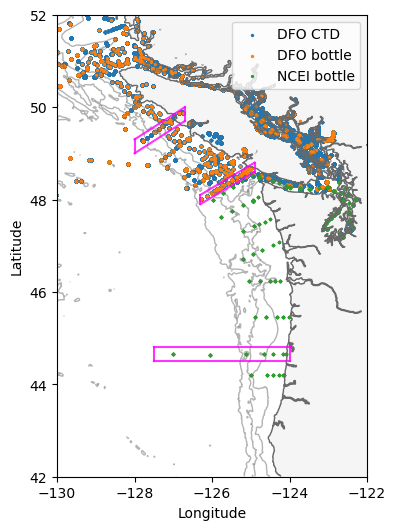

In [5]:
fig, ax = plt.subplots(1,1,figsize=(4, 6))

ax.contourf(grid.lon_rho, grid.lat_rho, grid.mask_rho, linewidths=1, levels=[-0.01, 0.01], colors='whitesmoke')
ax.contour(grid.lon_rho, grid.lat_rho, grid.mask_rho, linewidths=1, levels=[-0.01, 0.01], colors='dimgray')
ax.contour(grid.lon_rho, grid.lat_rho,grid.h, linewidths=1, levels=[200, 1000, 2000], colors='dimgray', alpha=0.5)
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
ax.set_ylim([42,52])
ax.set_xlim([-130,-122])


# plot the location of observations
ax.scatter(obs.lon[(obs.source=='dfo1') & (obs.name != 'bottle')], obs.lat[(obs.source=='dfo1') & (obs.name != 'bottle')], s=2, label="DFO CTD")
ax.scatter(obs.lon[(obs.source=='dfo1') & (obs.name == 'bottle')], obs.lat[(obs.source=='dfo1') & (obs.name == 'bottle')], s=2, label="DFO bottle")
ax.scatter(obs.lon[obs.source!='dfo1'], obs.lat[obs.source!='dfo1'], s=2, label="NCEI bottle")
ax.legend()

# plot lil boxes around areas that you want to compare
#newport line?
plt.plot([-127.5,-124],[44.8,44.8],c='magenta',alpha=0.8)
plt.plot([-127.5,-124],[44.5,44.5],c='magenta',alpha=0.8)
plt.plot([-127.5,-127.5],[44.8,44.5],c='magenta',alpha=0.8)
plt.plot([-124,-124],[44.8,44.5],c='magenta',alpha=0.8)

#nice lil line near jdf entrance
plt.plot([-126.3,-126.3],[47.9,48.1],c='magenta',alpha=0.8)
plt.plot([-124.9,-124.9],[48.6,48.8],c='magenta',alpha=0.8)
plt.plot([-126.3,-124.9],[48.1,48.8],c='magenta',alpha=0.8)
plt.plot([-124.9,-126.3],[48.6,47.9],c='magenta',alpha=0.8)

#nice lil line a bit further up north
plt.plot([-128,-126.7],[49,49.7],c='magenta',alpha=0.8)
plt.plot([-128,-126.7],[49.3,50],c='magenta',alpha=0.8)
plt.plot([-126.7,-126.7],[49.7,50],c='magenta',alpha=0.8)
plt.plot([-128,-128],[49,49.3],c='magenta',alpha=0.8)


In [51]:
def cs(data,h,ax,tracer,title,xlabel,ylabel):
    if tracer == 'Salinity':
        level=np.linspace(31,35+1,50)
        Z = data.SA
        cmap=cm.haline
        lpad = -15
        unit = 'g/kg'

    elif tracer == 'CT':
        level=np.linspace(1,16+1,50)
        Z = data.CT
        cmap=cm.thermal
        lpad = -15
        unit = '$^\circ C$'
        
    elif tracer == 'DO':
        level=np.linspace(10,300+1,50)
        Z = data['DO (uM)']
        cmap=cm.ice
        lpad = -25
        unit = 'uM'

    elif tracer == '$NO_3$':
        level=np.linspace(5,46+1,50)
        Z = data['NO3 (uM)']
        cmap=cm.speed
        lpad = -15
        unit = 'uM'

    elif tracer == 'TA':
        level=np.linspace(2250,2600+1,50)
        Z = data['TA (uM)']
        cmap=cm.matter
        lpad = -25
        unit = 'uM'

    zi = griddata((data.lon, data.z), Z, (xi[None, :], yi[:, None]), method='linear')
    im = ax.contourf(xi,yi,zi,levels=level,cmap=cmap)
    cb = fig.colorbar(im, ax=ax)
    cb.set_ticks([np.min(level),np.max(level)])
    cb.set_label(label=unit,labelpad=lpad)

    # ax.scatter(data.lon,data.z,s=0.05,color='k',alpha=0.5)
    ax.fill_between(data.lon, h*-1, np.min(h*-1), color='whitesmoke')
    ax.set_ylim([np.min(h*-1)*0.9,0])
    
    if title == True:
        ax.set_title(tracer)
    
    if ylabel == True:
        ax.set_ylabel('Depth (m)')
    else:
        ax.set_yticks([])
        ax.set_ylabel('')

    if xlabel == True:
        ax.set_xticks([np.round(np.min(data.lon),1)+0.1,np.round(np.max(data.lon),1)-0.1])
    else:
        ax.set_xticks([])

   


def cs_diff(os,ms,ax,tracer,title,xlabel,ylabel):
    if tracer == 'Salinity':
        level=np.linspace(-2,2+0.000001,50)
        Z = ms.SA-os.SA
        lpad = -15
        unit = 'g/kg'

    elif tracer == 'CT':
        level=np.linspace(-5,5+0.000001,50)
        Z = ms.CT-os.CT
        lpad = -15
        unit = '$^\circ C$'
        
    elif tracer == 'DO':
        level=np.linspace(-100,100+0.000001,50)
        Z = ms['DO (uM)']-os['DO (uM)']
        lpad = -25
        unit = 'uM'

    elif tracer == '$NO_3$':
        level=np.linspace(-20,20+0.000001,50)
        Z = ms['NO3 (uM)']-os['NO3 (uM)']
        cmap=cm.speed
        lpad = -15
        unit = 'uM'

    elif tracer == 'TA':
        level=np.linspace(-100,100+0.000001,50)
        Z = ms['TA (uM)']-os['TA (uM)']
        cmap=cm.matter
        lpad = -25
        unit = 'uM'

    cmap=cm.balance

    zi = griddata((os.lon, os.z), Z, (xi[None, :], yi[:, None]), method='linear')
    im = ax.contourf(xi,yi,zi,levels=level,cmap=cmap)
    cb = fig.colorbar(im, ax=ax)
    cb.set_ticks([np.min(level),np.max(level)])
    cb.set_label(label=unit,labelpad=lpad)
    
    # ax.scatter(os.lon,os.z,s=0.05,color='k',alpha=0.5)
    ax.fill_between(os.lon, ms.h*-1, np.min(ms.h*-1), color='whitesmoke')
    ax.set_ylim([np.min(ms.h*-1)*0.9,0])
    
    if title == True:
        ax.set_title(tracer)
    
    if ylabel == True:
        ax.set_ylabel('Depth (m)')
    else:
        ax.set_yticks([])
        ax.set_ylabel('')

    if xlabel == True:
        ax.set_xticks([np.round(np.min(os.lon),1)+0.1,np.round(np.max(os.lon),1)-0.1])
    else:
        ax.set_yticks([])

# newport line

In [52]:

os = obs[(obs.lat>44.5)&(obs.lat<44.8)]
ms = mod[(mod.lat>44.5)&(mod.lat<44.8)]

In [53]:
np.max(os.time) - np.min(os.time) # all measurements taken within one day, so no need to split up

Timedelta('0 days 23:40:43')

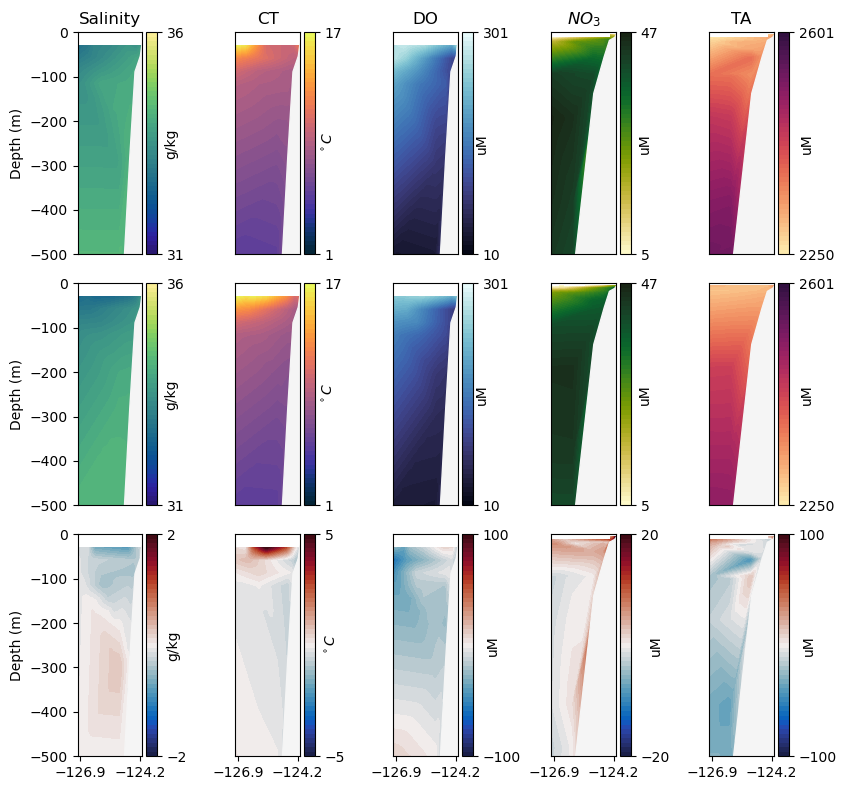

In [54]:
# Create grid values first.
ngridx = 100
ngridy = 100
xi = np.linspace(min(os.lon),max(os.lon), ngridx)
yi = np.linspace(0, min(os.z), ngridy)

fig, ax = plt.subplots(3,5,figsize=[8.5,8])

# ################
# ##    obs     ##
# ################
cs(os,ms.h,ax[0,0],'Salinity',True,False,True)
cs(os,ms.h,ax[0,1],'CT',True,False,False)
cs(os,ms.h,ax[0,2],'DO',True,False,False)
cs(os,ms.h,ax[0,3],'$NO_3$',True,False,False)
cs(os,ms.h,ax[0,4],'TA',True,False,False)


# ################
# ##    mod     ##
# ################
cs(ms,ms.h,ax[1,0],'Salinity',False,False,True)
cs(ms,ms.h,ax[1,1],'CT',False,False,False)
cs(ms,ms.h,ax[1,2],'DO',False,False,False)
cs(ms,ms.h,ax[1,3],'$NO_3$',False,False,False)
cs(ms,ms.h,ax[1,4],'TA',False,False,False)

# ##################
# ##    diff!     ##
# ##################
cs_diff(os,ms,ax[2,0],'Salinity',False,True,True)
cs_diff(os,ms,ax[2,1],'CT',False,True,False)
cs_diff(os,ms,ax[2,2],'DO',False,True,False)
cs_diff(os,ms,ax[2,3],'$NO_3$',False,True,False)
cs_diff(os,ms,ax[2,4],'TA',False,True,False)


for axs in ax:
    axs[0].set_ylim([-500,0])
    axs[1].set_ylim([-500,0])
    axs[2].set_ylim([-500,0])

plt.tight_layout()

# north
the only thing that has to change here is that the definition of the cross section gets a bit more complicated

In [55]:
#define the upper lat division: lat < 0.54lon + 118.52
# lower lat division: lat > 0.54lon + 118.22
# lon > -128
# lon < -126.7

os = obs[(obs.lat < 0.54*obs.lon + 118.52) & (obs.lat > 0.54*obs.lon + 118.22) & (obs.lon > -128) & (obs.lon < -126.7)]
ms = mod[(obs.lat < 0.54*obs.lon + 118.52) & (obs.lat > 0.54*obs.lon + 118.22) & (obs.lon > -128) & (obs.lon < -126.7)]

# few different periods with obs, 2017 by far the richest, with measurements taken in july and sep
os = os[(os.time > datetime.datetime(2017,9,1,0,0,0)) & (os.time < datetime.datetime(2017,9,30,0,0,0))]
ms = ms[(ms.time > datetime.datetime(2017,9,1,0,0,0)) & (ms.time < datetime.datetime(2017,9,30,0,0,0))]

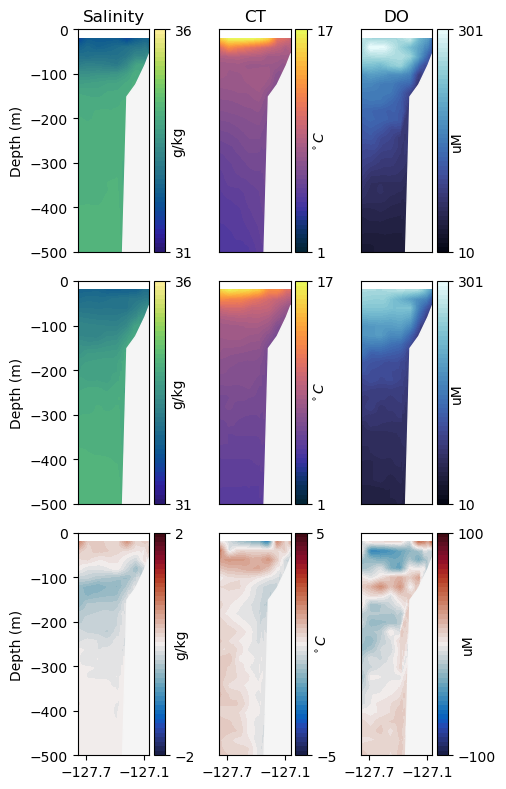

In [56]:
# Create grid values first.
ngridx = 100
ngridy = 100
xi = np.linspace(min(os.lon),max(os.lon), ngridx)
yi = np.linspace(0, min(os.z), ngridy)

n=3
fig, ax = plt.subplots(3,n,figsize=[(8.5/5)*n,8])

# ################
# ##    obs     ##
# ################
cs(os,ms.h,ax[0,0],'Salinity',True,False,True)
cs(os,ms.h,ax[0,1],'CT',True,False,False)
cs(os,ms.h,ax[0,2],'DO',True,False,False)

# ################
# ##    mod     ##
# ################
cs(ms,ms.h,ax[1,0],'Salinity',False,False,True)
cs(ms,ms.h,ax[1,1],'CT',False,False,False)
cs(ms,ms.h,ax[1,2],'DO',False,False,False)

# ##################
# ##    diff!     ##
# ##################
cs_diff(os,ms,ax[2,0],'Salinity',False,True,True)
cs_diff(os,ms,ax[2,1],'CT',False,True,False)
cs_diff(os,ms,ax[2,2],'DO',False,True,False)

for axs in ax:
    axs[0].set_ylim([-500,0])
    axs[1].set_ylim([-500,0])
    axs[2].set_ylim([-500,0])

plt.tight_layout()

# north of jdf entrance

In [57]:
#define the upper lat division: lat < 0.5lon + 111.25
# lower lat division: lat > 0.5lon + 111.05
# lon > -126.3
# lon < -124.9

os = obs[(obs.lat < 0.5*obs.lon + 111.25) & (obs.lat > 0.5*obs.lon + 111.05) & (obs.lon > -126.3) & (obs.lon < -124.9)]
ms = mod[(obs.lat < 0.5*obs.lon + 111.25) & (obs.lat > 0.5*obs.lon + 111.05) & (obs.lon > -126.3) & (obs.lon < -124.9)]

# multiple periods of sampling in 2017, all summer (may, july, sep)

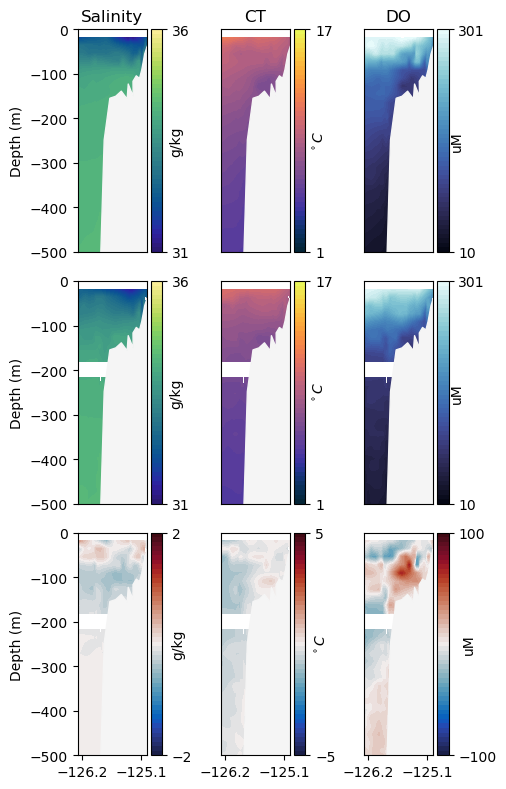

In [58]:
#2017 May

os = obs[(obs.lat < 0.5*obs.lon + 111.25) & (obs.lat > 0.5*obs.lon + 111.05) & (obs.lon > -126.3) & (obs.lon < -124.9)]
ms = mod[(obs.lat < 0.5*obs.lon + 111.25) & (obs.lat > 0.5*obs.lon + 111.05) & (obs.lon > -126.3) & (obs.lon < -124.9)]
os = os[(os.time > datetime.datetime(2017,1,1,0,0,0)) & (os.time < datetime.datetime(2017,6,1,0,0,0))]
ms = ms[(ms.time > datetime.datetime(2017,1,1,0,0,0)) & (ms.time < datetime.datetime(2017,6,1,0,0,0))]

# Create grid values first.
ngridx = 100
ngridy = 100
xi = np.linspace(min(os.lon),max(os.lon), ngridx)
yi = np.linspace(0, min(os.z), ngridy)

n=3
fig, ax = plt.subplots(3,n,figsize=[(8.5/5)*n,8])

# ################
# ##    obs     ##
# ################
cs(os,ms.h,ax[0,0],'Salinity',True,False,True)
cs(os,ms.h,ax[0,1],'CT',True,False,False)
cs(os,ms.h,ax[0,2],'DO',True,False,False)

# ################
# ##    mod     ##
# ################
cs(ms,ms.h,ax[1,0],'Salinity',False,False,True)
cs(ms,ms.h,ax[1,1],'CT',False,False,False)
cs(ms,ms.h,ax[1,2],'DO',False,False,False)

# ##################
# ##    diff!     ##
# ##################
cs_diff(os,ms,ax[2,0],'Salinity',False,True,True)
cs_diff(os,ms,ax[2,1],'CT',False,True,False)
cs_diff(os,ms,ax[2,2],'DO',False,True,False)

for axs in ax:
    axs[0].set_ylim([-500,0])
    axs[1].set_ylim([-500,0])
    axs[2].set_ylim([-500,0])


plt.tight_layout()

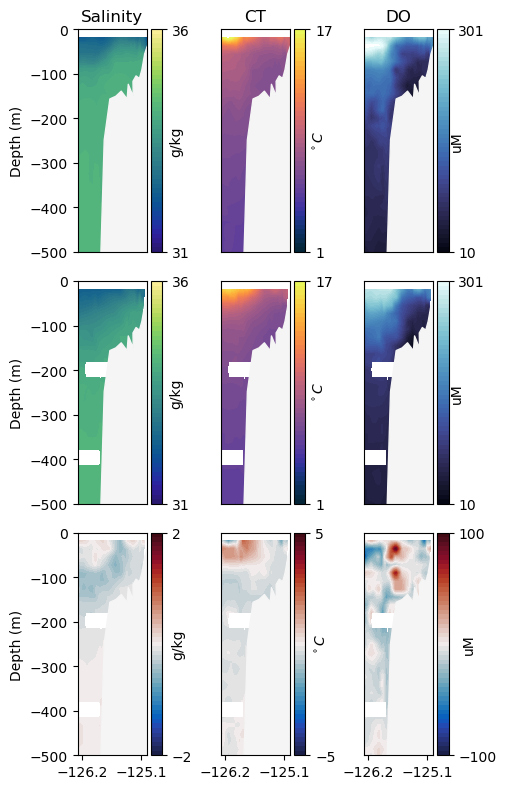

In [59]:
#2017 May

os = obs[(obs.lat < 0.5*obs.lon + 111.25) & (obs.lat > 0.5*obs.lon + 111.05) & (obs.lon > -126.3) & (obs.lon < -124.9)]
ms = mod[(obs.lat < 0.5*obs.lon + 111.25) & (obs.lat > 0.5*obs.lon + 111.05) & (obs.lon > -126.3) & (obs.lon < -124.9)]
os = os[(os.time > datetime.datetime(2017,8,25,0,0,0)) & (os.time < datetime.datetime(2017,12,31,0,0,0))]
ms = ms[(ms.time > datetime.datetime(2017,8,25,0,0,0)) & (ms.time < datetime.datetime(2017,12,31,0,0,0))]

# Create grid values first.
ngridx = 100
ngridy = 100
xi = np.linspace(min(os.lon),max(os.lon), ngridx)
yi = np.linspace(0, min(os.z), ngridy)

n=3
fig, ax = plt.subplots(3,n,figsize=[(8.5/5)*n,8])

# ################
# ##    obs     ##
# ################
cs(os,ms.h,ax[0,0],'Salinity',True,False,True)
cs(os,ms.h,ax[0,1],'CT',True,False,False)
cs(os,ms.h,ax[0,2],'DO',True,False,False)

# ################
# ##    mod     ##
# ################
cs(ms,ms.h,ax[1,0],'Salinity',False,False,True)
cs(ms,ms.h,ax[1,1],'CT',False,False,False)
cs(ms,ms.h,ax[1,2],'DO',False,False,False)

# ##################
# ##    diff!     ##
# ##################
cs_diff(os,ms,ax[2,0],'Salinity',False,True,True)
cs_diff(os,ms,ax[2,1],'CT',False,True,False)
cs_diff(os,ms,ax[2,2],'DO',False,True,False)

for axs in ax:
    axs[0].set_ylim([-500,0])
    axs[1].set_ylim([-500,0])
    axs[2].set_ylim([-500,0])

plt.tight_layout()